# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [280]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import sys
import math

from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [353]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

In [282]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [283]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [284]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [285]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,MOBI_REGIO,person,ordinal,[-1]
freq,1,43,49,26


In [286]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


In [287]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(feat_info.head(15))

                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GF

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [288]:
feat_info['missing_or_unknown'].head()

0      [-1,0]
1    [-1,0,9]
2      [-1,0]
3         [0]
4        [-1]
Name: missing_or_unknown, dtype: object

In [289]:
# Identify missing or unknown data values and convert them to NaNs.

# Creating a list of lists of missing or unknown value codes for every column.
nan_values_by_column = []

for missing_values in feat_info['missing_or_unknown']:
    missing_values = missing_values.replace('[', '').replace(']', '')
    missing_values = missing_values.split(',')
    
    if(missing_values[0] == ''):
        missing_values = []
        
    for i in range(len(missing_values)):
        value = missing_values[i]
        
        if(value == 'X' or value == 'XX'):
            missing_values[i] = value
            continue;
            
        missing_values[i] = int(value)
            
    nan_values_by_column.append(missing_values)

print(nan_values_by_column[0], nan_values_by_column[57], nan_values_by_column[58], nan_values_by_column[84])

[-1, 0] [-1, 'X'] ['XX'] [-1, 9]


In [290]:
# Code for a progress bar
toolbar_width = azdias.shape[1];
sys.stdout.write("Nan replacement progress: ");
sys.stdout.write("[%s]" % (" "));
sys.stdout.flush();
sys.stdout.write("\b" * (toolbar_width+1));

# Applying said list to replace those values with a NaN value.
for column_name in azdias:
    sys.stdout.write("-");
    sys.stdout.flush();
    column_index = (azdias.columns.get_loc(column_name));
    column = azdias[column_name];
    
    if(len(nan_values_by_column[column_index]) == 0):
        continue;
        
    azdias[column_name] = azdias[column_name].replace(nan_values_by_column[column_index], np.nan);
            
# End progress bar
sys.stdout.write(" ]\n");

nans_total = azdias.isnull().sum().sum();
azdias_size = azdias.shape[0]*azdias.shape[1]

nan_percentage = (nans_total / azdias_size) * 100

print('\nNumber of NaNs in dataset:', str(nans_total)+'/'+str(azdias_size), '(' + "{:.2f}".format(nan_percentage) + '%)', '\n');

Nan replacement progress: [------------------------------------------------------------------------------------- ]

Number of NaNs in dataset: 8373929/75753785 (11.05%) 



#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [291]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

vc_nulls = azdias.apply(lambda x: x.isnull().value_counts() * 100/azdias.shape[0]).T[True]
vc_nulls.head(20)

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                      NaN
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST              NaN
FINANZ_SPARER                  NaN
FINANZ_VORSORGER               NaN
FINANZ_ANLEGER                 NaN
FINANZ_UNAUFFAELLIGER          NaN
FINANZ_HAUSBAUER               NaN
FINANZTYP                      NaN
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE               NaN
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
Name: True, dtype: float64

In [292]:
vc_nulls_sorted = vc_nulls.sort_values(na_position='first')

i = 0

custom_palette = {}
for index, val in vc_nulls_sorted.iteritems():
    
    information_level = feat_info.at[i, 'information_level']
        
    if(information_level == 'person'):
        custom_palette[index] = 'red'
    elif(information_level == 'household'):
        custom_palette[index] = 'green'
    elif(information_level == 'building'):
        custom_palette[index] = 'yellow'
    elif(information_level == 'microcell_rr4'):
        custom_palette[index] = 'blue'
    elif(information_level == 'microcell_rr3'):
        custom_palette[index] = 'orange'
    elif(information_level == 'postcode'):
        custom_palette[index] = 'purple'
    elif(information_level == 'region_rr1'):
        custom_palette[index] = 'pink'
    elif(information_level == 'macrocell_plz8'):
        custom_palette[index] = 'cyan'
    elif(information_level == 'community'):
        custom_palette[index] = 'brown'
    else:
        custom_palette[index] = 'black'
        
    i += 1

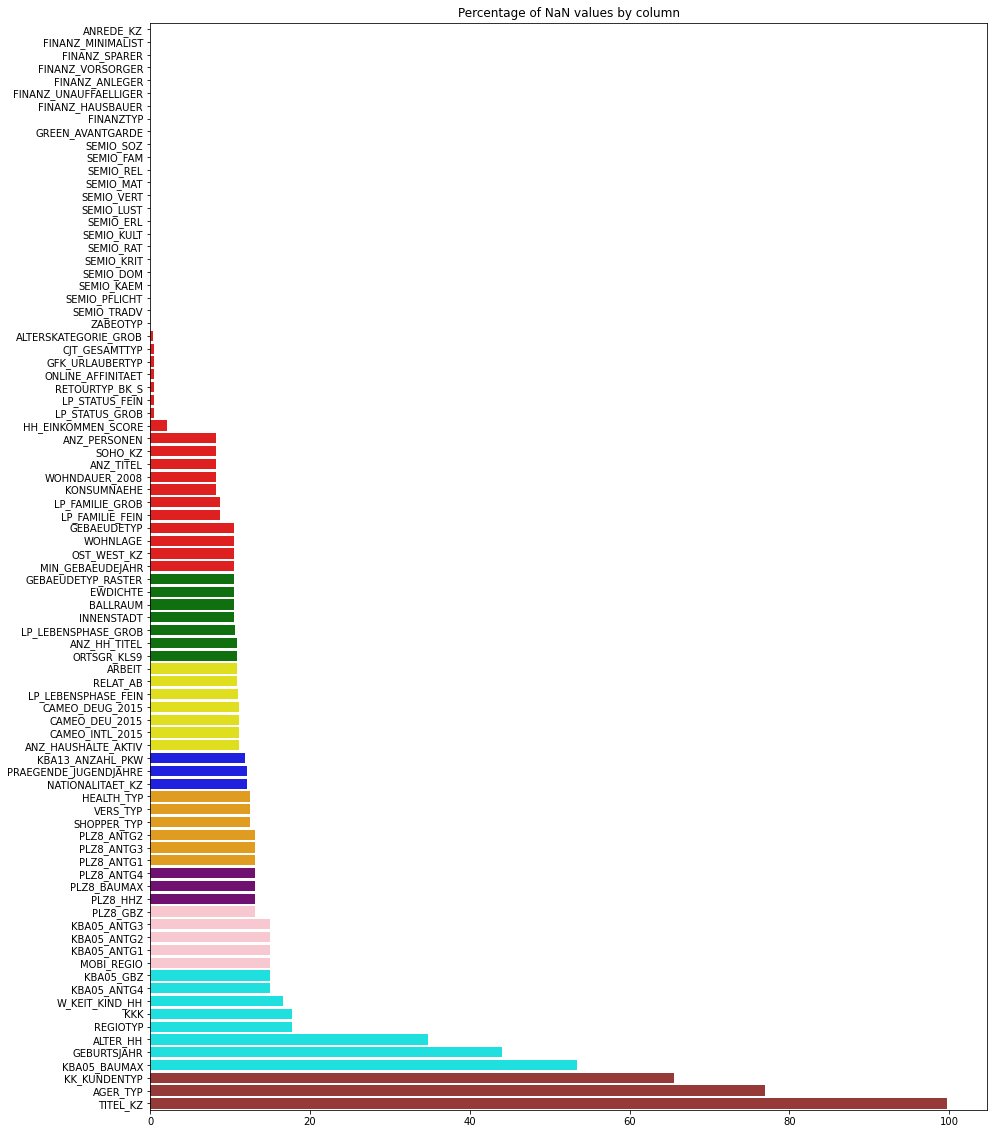

In [293]:
# Investigate patterns in the amount of missing data in each column.

plt.figure(figsize=(15, 20))
sns.barplot(x=vc_nulls_sorted.values, y=vc_nulls_sorted.index, palette=custom_palette).set_title('Percentage of NaN values by column');

In [294]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias_removed_columns = azdias.loc[:, azdias.isnull().mean() >= .20]
azdias_reduced_columns = azdias.loc[:, azdias.isnull().mean() < .20]

In [295]:
print('The following were the removed columns:')
list(azdias_removed_columns.columns)

The following were the removed columns:


['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [296]:
vc_nulls = azdias_reduced_columns.apply(lambda x: x.isnull().value_counts() * 100/azdias.shape[0]).T[True]

In [297]:
vc_nulls_sorted = vc_nulls.sort_values(na_position='first')

i = 0

custom_palette = {}
for index, val in vc_nulls_sorted.iteritems():
    
    information_level = feat_info.at[i, 'information_level']
        
    if(information_level == 'person'):
        custom_palette[index] = 'red'
    elif(information_level == 'household'):
        custom_palette[index] = 'green'
    elif(information_level == 'building'):
        custom_palette[index] = 'yellow'
    elif(information_level == 'microcell_rr4'):
        custom_palette[index] = 'blue'
    elif(information_level == 'microcell_rr3'):
        custom_palette[index] = 'orange'
    elif(information_level == 'postcode'):
        custom_palette[index] = 'purple'
    elif(information_level == 'region_rr1'):
        custom_palette[index] = 'pink'
    elif(information_level == 'macrocell_plz8'):
        custom_palette[index] = 'cyan'
    elif(information_level == 'community'):
        custom_palette[index] = 'brown'
    else:
        custom_palette[index] = 'black'
        
    i += 1

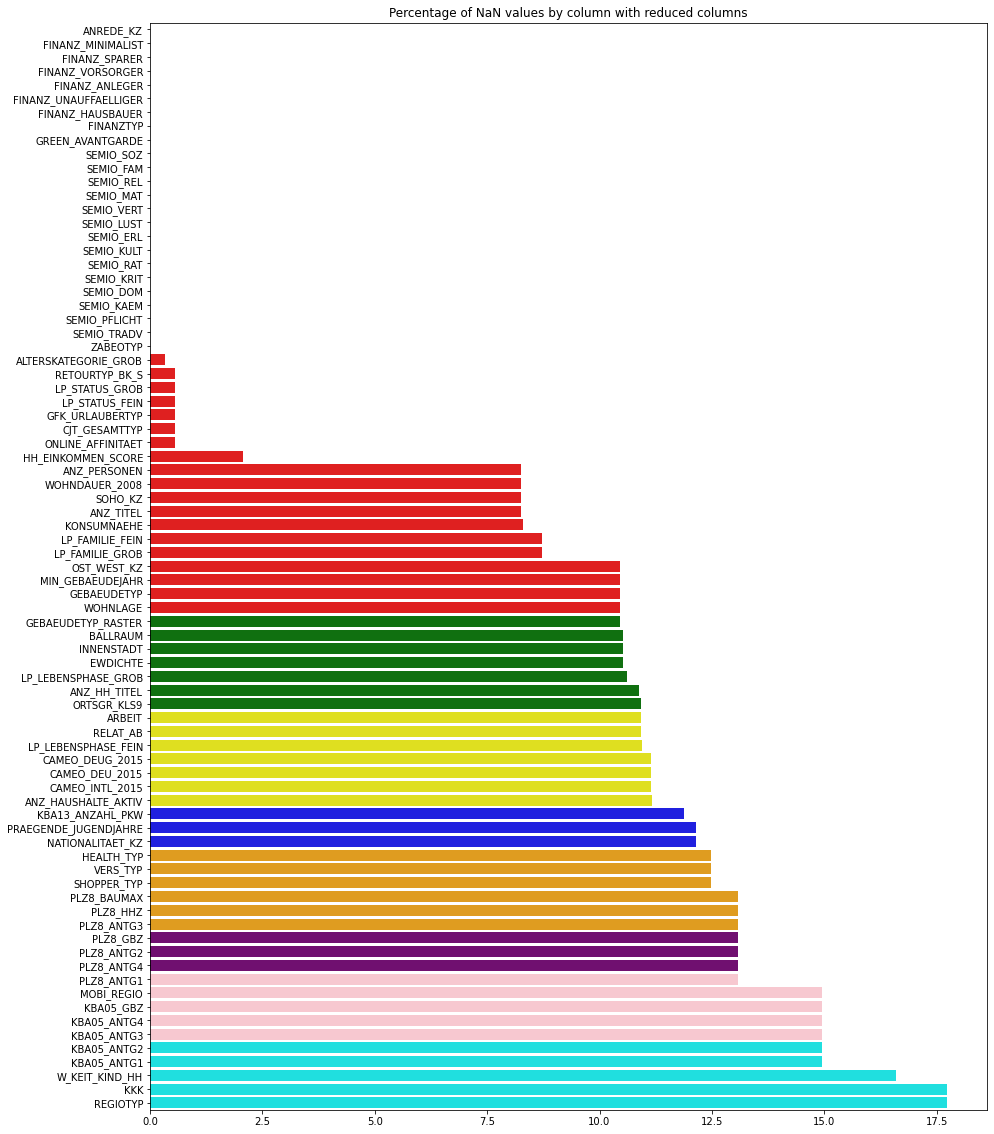

In [298]:
vc_nulls_sorted = vc_nulls.sort_values(na_position='first')

plt.figure(figsize=(15, 20));
sns.barplot(x=vc_nulls_sorted.values, y=vc_nulls_sorted.index, palette=custom_palette).set_title('Percentage of NaN values by column with reduced columns');

#### Discussion 1.1.2: Assess Missing Data in Each Column

After analysing the data, I plotted a graph to show the percentage of missing values by each individual column. In my observations, the features that had to do with community data had a overwhelming amount of missing values, with one reaching as high as 99%. For some macro-cell features, there were also some outlier attributes. What I then observed is that columns with percentages of missing values above 20% tended to be abnormaly high.

For this reason, I decided upon a threshold of acceptance for NaN value percentages of 20%. This means that any column with values above 20% of NaN values were removed from the dataset, as demonstrated by the graph above. The removed columns ended up being AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP and KBA05_BAUMAX.

Another observation is that by plotting the missing data proportions with a class indicating which information_level the given column belongs to, it can be seen that the information levels macrocell_plz8 and community, which describe more regional data, tend to have considerably more missing values.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [299]:
# How much data is missing in each row of the dataset?

n_columns = azdias_reduced_columns.shape[1]

row_nan_percentage = azdias_reduced_columns.apply(lambda x: 1-(x.count()/n_columns), axis=1)

In [300]:
print(row_nan_percentage)

0         0.544304
1         0.000000
2         0.000000
3         0.088608
4         0.000000
            ...   
891216    0.037975
891217    0.050633
891218    0.063291
891219    0.000000
891220    0.000000
Length: 891221, dtype: float64


In [301]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

rows_with_high_nans = row_nan_percentage.where(row_nan_percentage > 0.25).dropna()
rows_with_low_nans = row_nan_percentage.where(row_nan_percentage <= 0.25).dropna()

print(rows_with_high_nans.head(), '\n')
print(rows_with_low_nans.head(), '\n')

0     0.544304
11    0.594937
14    0.594937
17    0.594937
24    0.594937
dtype: float64 

1    0.000000
2    0.000000
3    0.088608
4    0.000000
5    0.000000
dtype: float64 



In [302]:
azdias_with_high_nans = azdias_reduced_columns.drop(rows_with_low_nans.index)
azdias_with_high_nans.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [303]:
azdias_with_low_nans = azdias_reduced_columns.drop(rows_with_high_nans.index)
azdias_with_low_nans.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [304]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_groups(column):
    plt.figure(figsize = [15, 4]) 
    
    plt.subplot(1, 2, 1);
    plt.title('Group with few missing values');
    sns.countplot(data=azdias_with_high_nans, x=column, color='b');
    
    plt.subplot(1, 2, 2);
    plt.title('Group with many missing values');
    sns.countplot(data=azdias_with_low_nans, x=column, color='b');

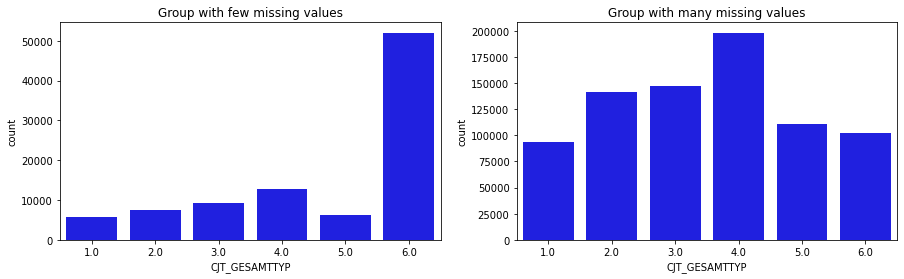

In [305]:
compare_groups('CJT_GESAMTTYP')

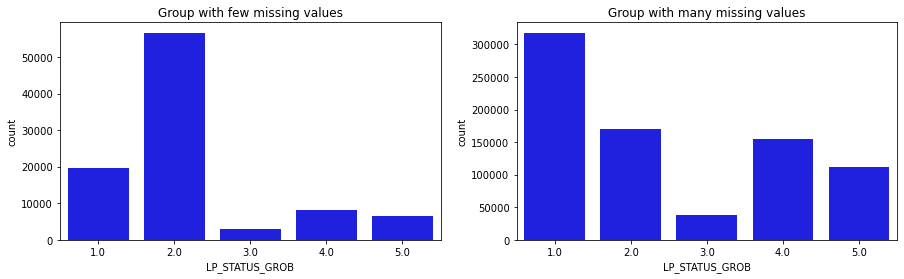

In [306]:
compare_groups('LP_STATUS_GROB')

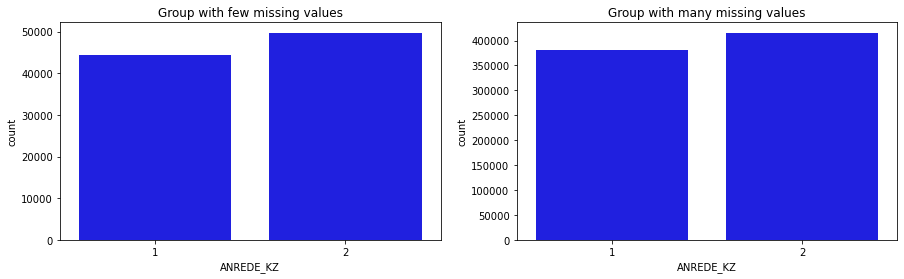

In [307]:
compare_groups('ANREDE_KZ')

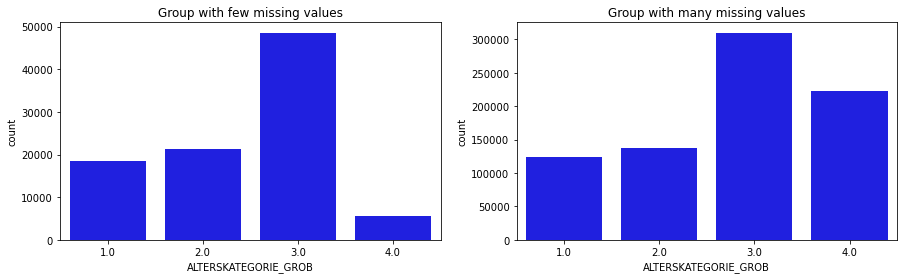

In [308]:
compare_groups('ALTERSKATEGORIE_GROB')

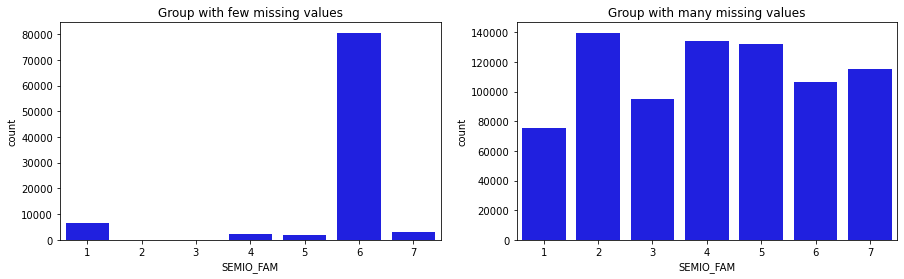

In [309]:
compare_groups('SEMIO_FAM')

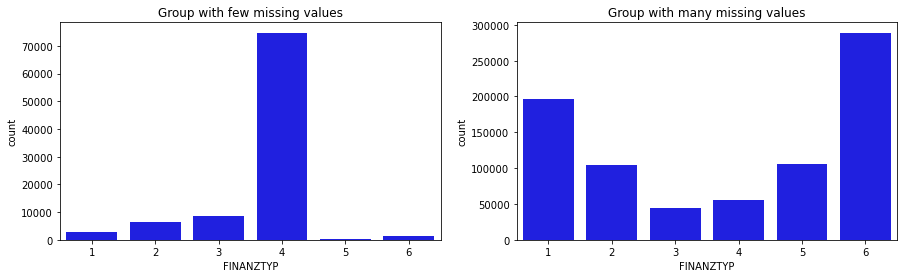

In [310]:
compare_groups('FINANZTYP')

#### Discussion 1.1.3: Assess Missing Data in Each Row

For this section, I decided to have a threshold of 25% for missing value proportions. This means I divided rows based on wheter they are above or below this threshold. Across most columns, the rows with few missing values showed presented a very high difference in the distributions, in comparison to the rows with many, showing that there is in fact some qualitative difference between them.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [311]:
has_missing = azdias_with_low_nans.isnull().values.any()
print(has_missing)

True


In [312]:
azdias_without_nans = azdias_with_low_nans.dropna()
has_missing = azdias_without_nans.isnull().values.any()
print(has_missing)

False


(0.0, 85.0)

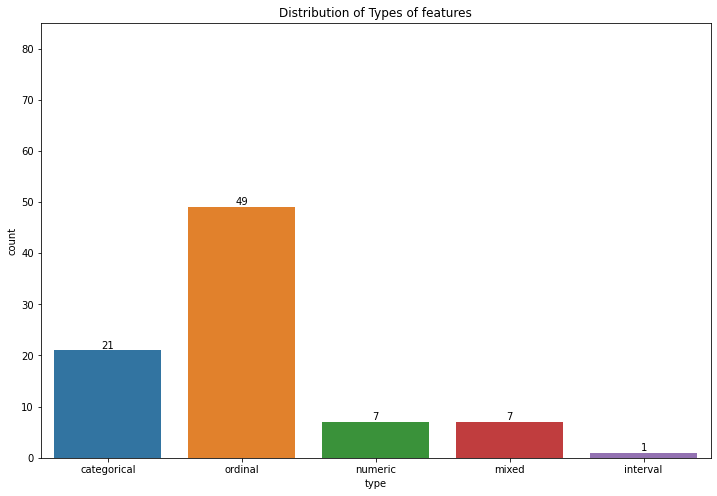

In [313]:
# How many features are there of each data type?

plt.figure(figsize=(12,8));
plt.title('Distribution of Types of features');

ax = sns.countplot(data=feat_info, x='type');

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.0f}'.format(y), (x.mean(), y), ha='center', va='bottom')
    
ax.set_ylim(0, feat_info.shape[0])

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [314]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_attr = feat_info[feat_info['type'] == 'categorical'].attribute;

In [315]:
categorical_attr

0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [316]:
# The variables that I removed due to missing values also need to bee removed from this list.

categorical_attr = categorical_attr.drop(labels=[0, 40, 47])

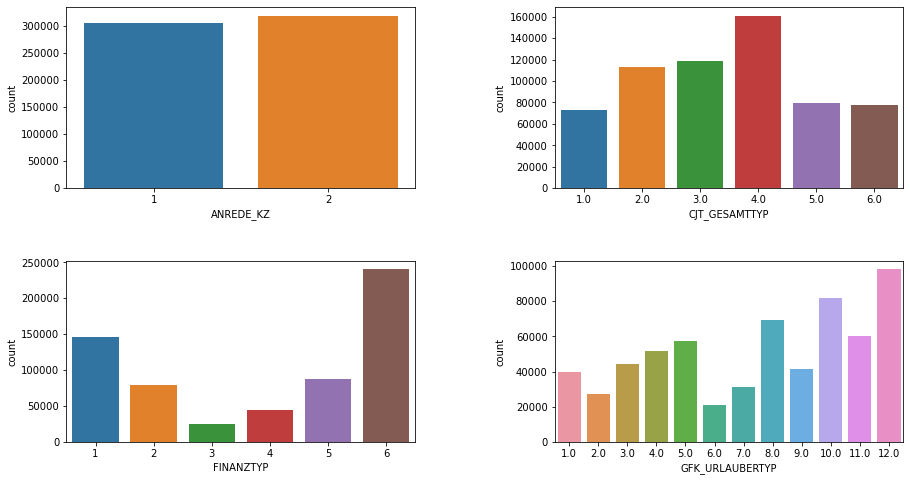

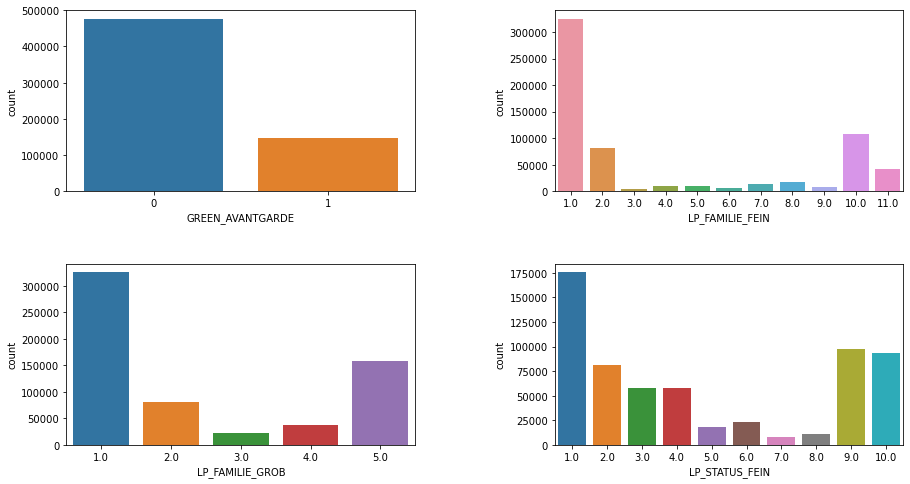

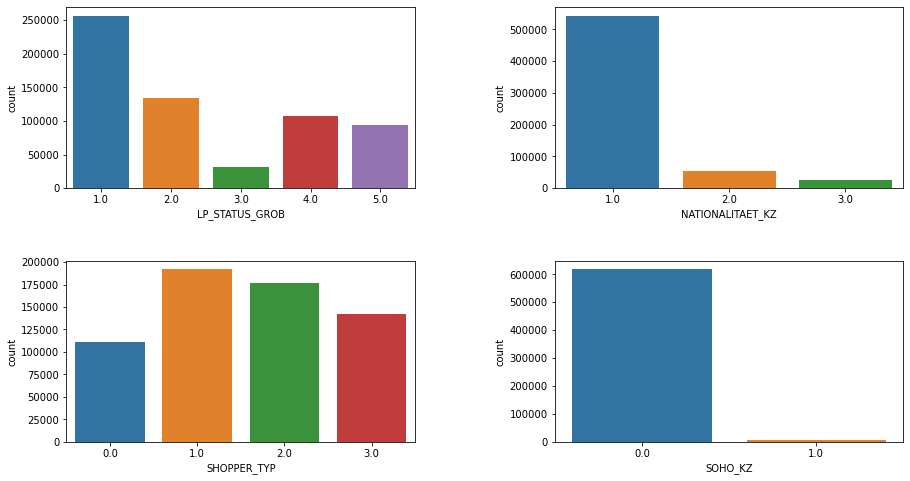

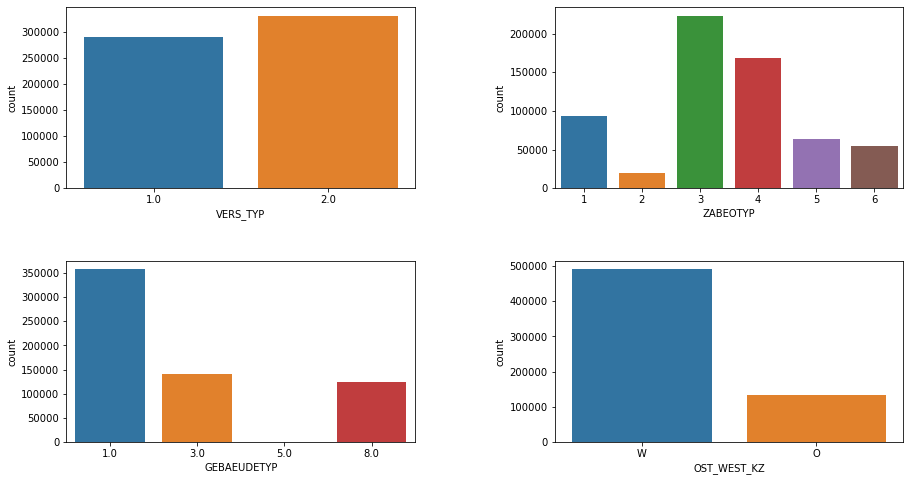

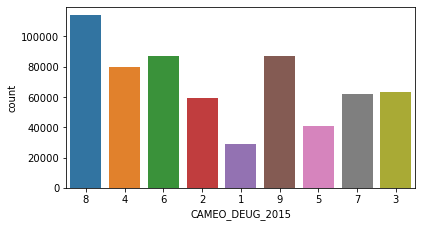

In [317]:
binary_attr = []
multilevel_attr = []

for i in range(0, len(categorical_attr)-1):
    if((i%4)+1 == 1):
        fig = plt.figure(figsize=(15,8))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        
    column = categorical_attr.iloc[i]
        
    if(azdias_without_nans[column].nunique() == 2):
        binary_attr.append(column)
    else:
        multilevel_attr.append(column)
    
    ax = fig.add_subplot(2, 2, (i%4)+1)
    sns.countplot(data=azdias_without_nans, x=column);

plt.show()

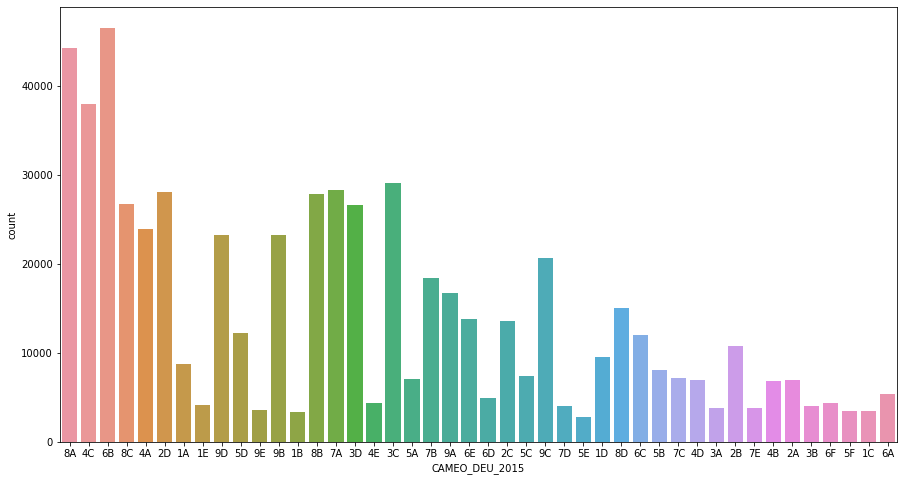

In [318]:
# I decided to plot the last column on its own because of the comparably high number of categories in it
fig = plt.figure(figsize=(15,8))
sns.countplot(data=azdias_without_nans, x='CAMEO_DEU_2015');

In [319]:
# And since it is a categorical multilevel attribute, it should be added to the multilevel_attr array.
# multilevel_attr.append('CAMEO_DEU_2015')

# However, since this attribute has way too many categories, there is a big chance it will clutter the transformed dataset,
# since it will create a dummy variable for every one of its 45 possible values. So I have decided to remove it from the
# analisys, denoting it as a special variable.

azdias_modified = azdias_without_nans.drop(['CAMEO_DEU_2015'], axis=1)

In [320]:
print('Binary attributes (', len(binary_attr),'): ', binary_attr, '\n')
print('Multi-level attributes (', len(multilevel_attr),'): ', multilevel_attr)

Binary attributes ( 5 ):  ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'] 

Multi-level attributes ( 12 ):  ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']


In [321]:
# Now to handle the special binary attribute case, I will be doing the following substitution.

azdias_modified = azdias_modified.replace({'OST_WEST_KZ': {'W': 0, 'O': 1}})

In [322]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_encoded = pd.get_dummies(azdias_modified, columns=multilevel_attr)
azdias_encoded.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'GEBAEUDETYP_8.0', 'CAMEO_DEUG_2015_1', 'CAMEO_DEUG_2015_2',
       'CAMEO_DEUG_2015_3', 'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5',
       'CAMEO_DEUG_2015_6', 'CAMEO_DEUG_2015_7', 'CAMEO_DEUG_2015_8',
       'CAMEO_DEUG_2015_9'],
      dtype='object', length=147)

#### Discussion 1.2.1: Re-Encode Categorical Features

I started by graphing the distributions of values of all the categorical columns, to see the different range of categories present in each attribute. I also programmatically separated the binary from the multilevel attributes. One particular column, 'CAMEO_DEU_2015', presented a range of values so high, that I decided to drop it from further analisys, since it would create way too many dummy variables after one-hot encoding. After that I manually engineered the 'OST_WEST_KZ' column to replace the 'W' and 'O' values with 0 and 1, respectively. In the end I then One-Hot encoded the multilevel variables from the dataset, creating an end dataset of 148 features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [323]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Decade:Number
def praeg_decade (row):
    praeg_label = row['PRAEGENDE_JUGENDJAHRE']
    
    if praeg_label >= 1 and praeg_label <= 2:
        return 40;
    if praeg_label >= 3 and praeg_label <= 4:
        return 50;
    if praeg_label >= 5 and praeg_label <= 7:
        return 60;
    if praeg_label >= 8 and praeg_label <= 9:
        return 70;
    if praeg_label >= 10 and praeg_label <= 13:
        return 80;
    if praeg_label >= 14 and praeg_label <= 15:
        return 90;
    return np.nan

In [324]:
azdias_encoded['decade'] = azdias_encoded.apply(lambda row: praeg_decade(row), axis=1)

In [325]:
azdias_encoded['decade'].head()

1    90
2    90
4    70
5    50
6    80
Name: decade, dtype: int64

In [326]:
# mainstream:0; avantgarde:1
def praeg_movement (row):
    praeg_label = row['PRAEGENDE_JUGENDJAHRE']
    
    if praeg_label == 1:
        return 0;
    if praeg_label == 2:
        return 1;
    if praeg_label == 3:
        return 0;
    if praeg_label == 4:
        return 1;
    if praeg_label == 5:
        return 0;
    if praeg_label == 6:
        return 0;
    if praeg_label == 7:
        return 0;
    if praeg_label == 8:
        return 1;
    if praeg_label == 9:
        return 0;
    if praeg_label == 10:
        return 1;
    if praeg_label == 11:
        return 0;
    if praeg_label == 12:
        return 1;
    if praeg_label == 13:
        return 0;
    if praeg_label == 14:
        return 1;
    if praeg_label == 15:
        return 0;
    return np.nan

In [327]:
azdias_encoded['movement'] = azdias_encoded.apply(lambda row: praeg_movement(row), axis=1)

In [328]:
azdias_encoded['movement'].head()

1    1
2    0
4    1
5    0
6    1
Name: movement, dtype: int64

In [329]:
azdias_encoded['CAMEO_INTL_2015']

1         51
2         24
4         43
5         54
6         22
          ..
891213    34
891214    23
891215    31
891219    51
891220    43
Name: CAMEO_INTL_2015, Length: 623209, dtype: object

In [330]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Wealthy:1; Prosperous:2; Comfortable:3; Less Afluent:4; Poorer:5
def cameo_wealthlevel (row):
    try:
        cameo_label = int(row['CAMEO_INTL_2015'])

        if cameo_label >= 11 and cameo_label <= 55:
            return cameo_label // 10;
    except:
        return np.nan

In [331]:
azdias_encoded['wealth_level'] = azdias_encoded.apply(lambda row: cameo_wealthlevel(row), axis=1)

In [332]:
azdias_encoded['wealth_level'].head()

1    5
2    2
4    4
5    5
6    2
Name: wealth_level, dtype: int64

In [333]:
# Pre-Family:1; Children:2; School Age Children:3; Older Families:4; Elders:5
def cameo_lifestage(row):
    try:
        cameo_label = int(row['CAMEO_INTL_2015'])
    
        if cameo_label >= 11 and cameo_label <= 55:
            return cameo_label % 10;
    
    except:
        return np.nan

In [334]:
azdias_encoded['lifestage'] = azdias_encoded.apply(lambda row: cameo_lifestage(row), axis=1)

In [335]:
azdias_encoded['lifestage'].head()

1    1
2    4
4    3
5    4
6    2
Name: lifestage, dtype: int64

In [336]:
# To analyze the other mixed columns, I will be graphing them in the same way I did the categorical values

mixed_attr = feat_info[feat_info['type'] == 'mixed'].attribute;

In [337]:
mixed_attr

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
64             KBA05_BAUMAX
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [338]:
# As with the categorical variables, the columns removed due to missing values also need to be removed from the 
# mixed attribute list.

mixed_attr = mixed_attr.drop(labels=[64])

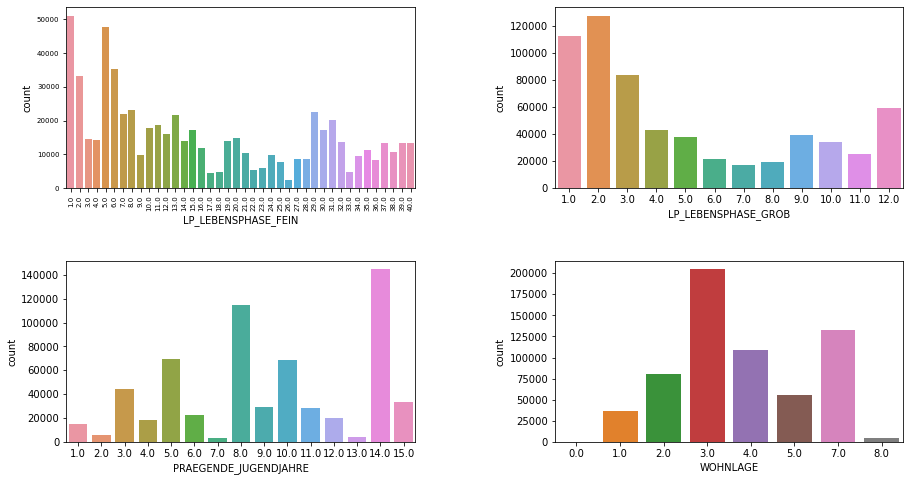

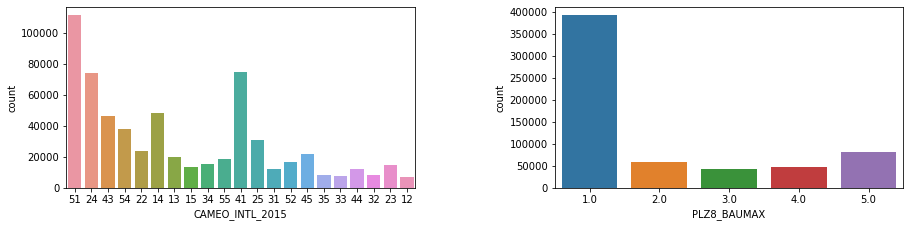

In [339]:
for i in range(0, len(mixed_attr)):
    if((i%4)+1 == 1):
        fig = plt.figure(figsize=(15,8))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        
    column = mixed_attr.iloc[i]
        
    ax = fig.add_subplot(2, 2, (i%4)+1)
    g = sns.countplot(data=azdias_encoded, x=column);

    if(i == 0):
        g.set_xticklabels(labels=g.get_xticklabels(), rotation=90)
        g.tick_params(labelsize=7)

plt.show()

In [340]:
azdias_encoded = azdias_encoded.drop(['LP_LEBENSPHASE_FEIN'], axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Having already dealt with the attributes PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015, and after veryfying that the columns WOHNLAGE and KBA05_BAUMAX cannot be disentangled, the columns that are left are "LP_LEBENSPHASE_FEIN" and "LP_LEBENSPHASE_GROB".

As it seems, "LP_LEBENSPHASE_FEIN" is a more detailed version of "LP_LEBENSPHASE_GROB", which roughly describes a persons life stage. These details would generate unnecessary noise in the dataset, and since the bulk of the information is present in "LP_LEBENSPHASE_GROB", it is safe to say that the more detailed version could be dropped. Being left with the reduced more rough version, it is very hard to disentangle, so it will be left as is.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [341]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
def show_df_info(df):
    percent_missing = df.isnull().sum() * 100 / len(azdias_encoded)
    column_types = df.dtypes

    raw_data = {'column': df.columns, 'nan_percentage': percent_missing, 'type': column_types}

    results = pd.DataFrame(raw_data, columns = ['column', 'nan_percentage', 'type'])

    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(results)

In [342]:
show_df_info(azdias_encoded)

                                      column  nan_percentage     type
ALTERSKATEGORIE_GROB    ALTERSKATEGORIE_GROB             0.0  float64
ANREDE_KZ                          ANREDE_KZ             0.0    int64
FINANZ_MINIMALIST          FINANZ_MINIMALIST             0.0    int64
FINANZ_SPARER                  FINANZ_SPARER             0.0    int64
FINANZ_VORSORGER            FINANZ_VORSORGER             0.0    int64
FINANZ_ANLEGER                FINANZ_ANLEGER             0.0    int64
FINANZ_UNAUFFAELLIGER  FINANZ_UNAUFFAELLIGER             0.0    int64
FINANZ_HAUSBAUER            FINANZ_HAUSBAUER             0.0    int64
GREEN_AVANTGARDE            GREEN_AVANTGARDE             0.0    int64
HEALTH_TYP                        HEALTH_TYP             0.0  float64
LP_LEBENSPHASE_GROB      LP_LEBENSPHASE_GROB             0.0  float64
PRAEGENDE_JUGENDJAHRE  PRAEGENDE_JUGENDJAHRE             0.0  float64
RETOURTYP_BK_S                RETOURTYP_BK_S             0.0  float64
SEMIO_SOZ           

In [343]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_final = azdias_encoded.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [344]:
def replace_nancodes(df):
    for column_name in df:
        column_index = (df.columns.get_loc(column_name))
        column = df[column_name]

        if(len(nan_values_by_column[column_index]) == 0):
            continue;

        df[column_name] = df[column_name].replace(nan_values_by_column[column_index], np.nan)
    
    return df;

In [345]:
# This attribute is being removed because it caused a mismatch between the customer and generalpop data columns.
multilevel_attr.remove('GEBAEUDETYP')

In [346]:
multilevel_attr

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'CAMEO_DEUG_2015']

In [369]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = replace_nancodes(df);
    
    # remove selected columns and rows, ...
    df_reduced_columns = df.drop(columns=list(azdias_removed_columns.columns))
    
    row_nan_percentage = df_reduced_columns.apply(lambda x: 1-(x.count()/n_columns), axis=1);
    rows_with_nans = row_nan_percentage.where(row_nan_percentage > 0).dropna();
    rows_with_low_nans = row_nan_percentage.where(row_nan_percentage <= 0.25).dropna();
        
    df_without_nans = df_reduced_columns.drop(rows_with_nans.index);
    df_with_high_nans = df_reduced_columns.drop(rows_with_low_nans.index);
        
    # select, re-encode, and engineer column values.
    df_modified = df_without_nans;
    try:
        df_modified = df_without_nans.drop(['CAMEO_DEU_2015'], axis=1);
    except:
        pass;
    df_modified = df_modified.replace({'OST_WEST_KZ': {'W': 0, 'O': 1}});
    
    df_modified_N = df_with_high_nans;
    try:
        df_modified_N = df_with_high_nans.drop(['CAMEO_DEU_2015'], axis=1);
    except:
        pass;
    df_modified_N = df_modified_N.replace({'OST_WEST_KZ': {'W': 0, 'O': 1}});
    
    # Removing column because of mismatch between the two datasets
    df_modified = df_modified.drop(['GEBAEUDETYP'], axis=1)

    df_modified_N = df_modified_N.drop(['GEBAEUDETYP'], axis=1)
        
    df_encoded = pd.get_dummies(df_modified, columns=multilevel_attr);
    
    df_encoded_N = pd.get_dummies(df_modified_N, columns=multilevel_attr);
        
    df_engineered = df_encoded;
    df_engineered['decade'] = df_engineered.apply(lambda row: praeg_decade(row), axis=1);
    df_engineered['movement'] = df_engineered.apply(lambda row: praeg_movement(row), axis=1);
    df_engineered['wealth_level'] = df_engineered.apply(lambda row: cameo_wealthlevel(row), axis=1);
    df_engineered['lifestage'] = df_engineered.apply(lambda row: cameo_lifestage(row), axis=1);
    
    df_engineered_N = df_encoded_N;
    df_engineered_N['decade'] = df_engineered_N.apply(lambda row: praeg_decade(row), axis=1);
    df_engineered_N['movement'] = df_engineered_N.apply(lambda row: praeg_movement(row), axis=1);
    df_engineered_N['wealth_level'] = df_engineered_N.apply(lambda row: cameo_wealthlevel(row), axis=1);
    df_engineered_N['lifestage'] = df_engineered_N.apply(lambda row: cameo_lifestage(row), axis=1);
            
    # Dataframe with no missing values
    df_final = df_engineered.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN'], axis=1);
    
    # Dataframe with high missing values
    df_final_N = df_engineered_N.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN'], axis=1);
    
    # Return the cleaned dataframe.
    return df_final, df_final_N;

In [370]:
df_cleaned, df_cleaned_N = clean_data(azdias);

In [371]:
print(df_cleaned.shape)
print(df_cleaned_N.shape)

(623209, 144)
(94144, 144)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [372]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

show_df_info(df_cleaned)

                                      column  nan_percentage     type
ALTERSKATEGORIE_GROB    ALTERSKATEGORIE_GROB             0.0  float64
ANREDE_KZ                          ANREDE_KZ             0.0    int64
FINANZ_MINIMALIST          FINANZ_MINIMALIST             0.0    int64
FINANZ_SPARER                  FINANZ_SPARER             0.0    int64
FINANZ_VORSORGER            FINANZ_VORSORGER             0.0    int64
FINANZ_ANLEGER                FINANZ_ANLEGER             0.0    int64
FINANZ_UNAUFFAELLIGER  FINANZ_UNAUFFAELLIGER             0.0    int64
FINANZ_HAUSBAUER            FINANZ_HAUSBAUER             0.0    int64
GREEN_AVANTGARDE            GREEN_AVANTGARDE             0.0    int64
HEALTH_TYP                        HEALTH_TYP             0.0  float64
LP_LEBENSPHASE_GROB      LP_LEBENSPHASE_GROB             0.0  float64
RETOURTYP_BK_S                RETOURTYP_BK_S             0.0  float64
SEMIO_SOZ                          SEMIO_SOZ             0.0    int64
SEMIO_FAM           

In [373]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
data = scaler.fit_transform(df_cleaned)

In [374]:
data

array([[-1.7462911 ,  0.97782476, -1.51222382, ...,  0.81988646,
         1.14788172, -1.25110753],
       [ 0.20210748,  0.97782476, -1.51222382, ..., -1.21968108,
        -0.90999737,  0.74982182],
       [ 0.20210748, -1.02267813,  0.69240603, ...,  0.81988646,
         0.46192202,  0.08284537],
       ...,
       [-0.77209181,  0.97782476, -1.51222382, ...,  0.81988646,
        -0.22403767, -1.25110753],
       [-1.7462911 , -1.02267813, -1.51222382, ...,  0.81988646,
         1.14788172, -1.25110753],
       [ 1.17630677, -1.02267813,  0.69240603, ..., -1.21968108,
         0.46192202,  0.08284537]])

### Discussion 2.1: Apply Feature Scaling

For this step, I created a function that displays a dataframe containing information about missing values and value types, so that untreated or uncleaned attributes can be easily spotted. After confirming the validity of the final cleaned dataset, I applied StandartScaler to the dataset, storing the scaled data in the variable `data`.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [375]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(data)

In [376]:
# Investigate the variance accounted for by each principal component.

def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [377]:
df_pca_results = pca_results(df_cleaned, pca)

In [378]:
df_pca_results

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,decade,movement,wealth_level,lifestage
Dimension 1,0.1081,-0.1126,0.0073,-0.1962,0.1355,-0.1075,0.0720,0.0741,0.1327,-0.1047,...,-0.0695,-0.0124,-0.0021,0.0297,0.0855,0.1068,0.0999,0.0997,0.1718,-0.1090
Dimension 2,0.0793,0.2217,0.0401,0.0631,-0.2092,0.2021,-0.1947,-0.2022,0.1004,-0.0150,...,-0.0431,-0.0060,0.0099,0.0114,0.0469,0.0279,-0.2254,-0.1043,0.0719,-0.0082
Dimension 3,0.0485,0.0190,-0.3453,0.1295,-0.0511,0.0465,-0.1510,-0.0392,-0.0642,0.0702,...,-0.0235,0.0006,-0.0067,-0.0012,0.0093,0.0205,-0.0515,-0.0603,0.0145,-0.0127
Dimension 4,0.0374,-0.0082,0.0709,0.0054,-0.0017,0.0017,-0.0538,0.0249,-0.0195,0.2026,...,-0.0363,0.0090,-0.0220,-0.0093,0.0055,0.0063,0.0194,-0.0891,-0.0225,0.0122
Dimension 5,0.0294,0.0585,-0.0508,0.0146,-0.0213,0.0351,0.0684,-0.1235,0.0145,-0.2408,...,0.0116,-0.0302,0.0199,0.0126,0.0572,0.0658,-0.0317,0.0942,0.1371,-0.0721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dimension 140,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,...,-0.0035,-0.0026,-0.0037,-0.0032,-0.0041,-0.0037,0.0000,-0.0000,0.0000,-0.0000
Dimension 141,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,...,0.0187,0.0139,0.0194,0.0167,0.0216,0.0194,0.0000,-0.0000,0.0000,0.0000
Dimension 142,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,...,0.0011,0.0008,0.0011,0.0010,0.0013,0.0011,0.0000,-0.0000,-0.0000,0.0000
Dimension 143,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,...,-0.0050,-0.0037,-0.0052,-0.0045,-0.0058,-0.0052,0.0000,0.0000,0.0000,0.0000


In [379]:
df_pca_results_modified = df_pca_results.drop(df_pca_results[df_pca_results['Explained Variance'] < 0.02].index)

In [380]:
def show_variances(df):
    dimensions = df.index.values
    variances = df['Explained Variance']

    total_variance = np.sum(variances)

    x = [dimension.split()[-1] for dimension in dimensions]
    y = variances

    plt.figure(figsize = [15, 4])
    plt.bar(x, y)

    # Labeling the axes
    plt.title('Cumulative explained variance: ' + str('{:.2f}'.format(total_variance*100)) + '%')
    plt.xlabel('Component Dimension')
    plt.ylabel('Explained Variance')

    # Dsiplay the plot
    plt.show()

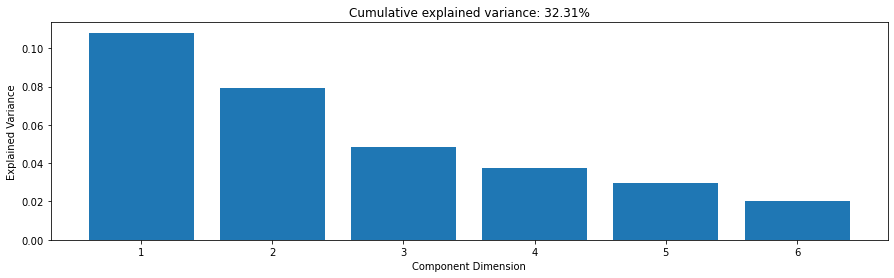

In [381]:
show_variances(df_pca_results_modified)

In [382]:
# For better visualization I will be removing components that have less than 0.65% explained variance.
df_pca_results_modified = df_pca_results.drop(df_pca_results[df_pca_results['Explained Variance'] < 0.0065].index)

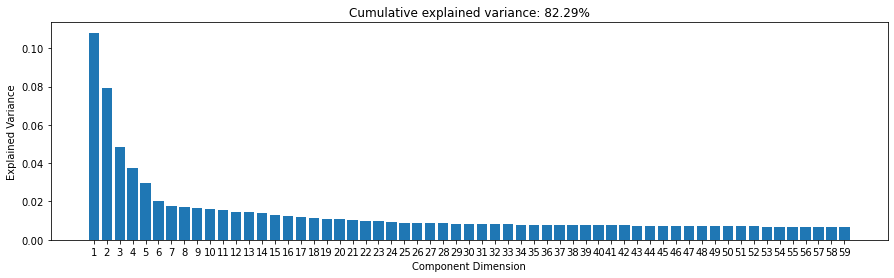

In [383]:
show_variances(df_pca_results_modified)

In [384]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=60)
X_pca = pca.fit_transform(data)

df_pca_results = pca_results(df_cleaned, pca)

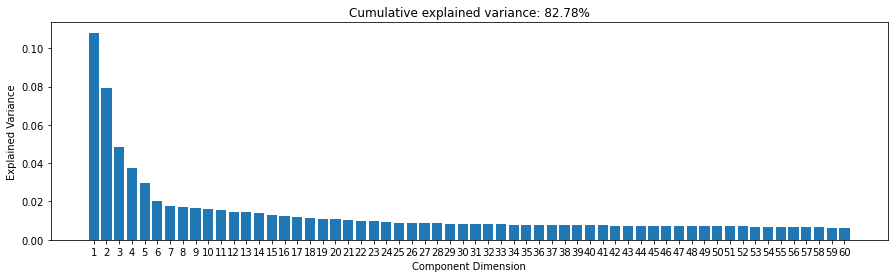

In [385]:
show_variances(df_pca_results)

### Discussion 2.2: Perform Dimensionality Reduction

For better visualization, I created a function to plot the components in regard to their respective explained variances, while also showing the cumulative explained variance. With this function I was able to determine that the first 6 principal components amassed over 30% of the explained variability.

After tinkering with this function using different thresholds of variance, I determined that to obtain a variance of just above 80% (which is a reasonable amount of variability from the original dataset), I would need around 60 principal components. So I ran PCA again with 60 components, obtaining the desired variance ratio. So going forward, 60 components will be used.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [386]:
def map_weights(df, pca, dimension, threshold):
    column_indexes = range(0, len(df.columns))
    
    feature_weights = pca.components_[dimension]
        
    raw_data = {'column_index': column_indexes, 'column': df.columns, 'feature_weights': feature_weights}
    df_results = pd.DataFrame(raw_data, columns = ['column_index', 'column', 'feature_weights'])
    
    # Sort results by feature weight
    df_results_sorted = df_results.reindex(df_results['feature_weights'].abs().sort_values().index)
    
    # Remove very low feature weights for better visualization
    df_results_modified = df_results_sorted.drop(df_results_sorted[abs(df_results_sorted['feature_weights']) < threshold].index)
    
    plt.figure(figsize = [17, 10])
    plt.title('PCA Component of Dimension ' + str(dimension))
    sns.barplot(data=df_results_modified, x='feature_weights', y='column')

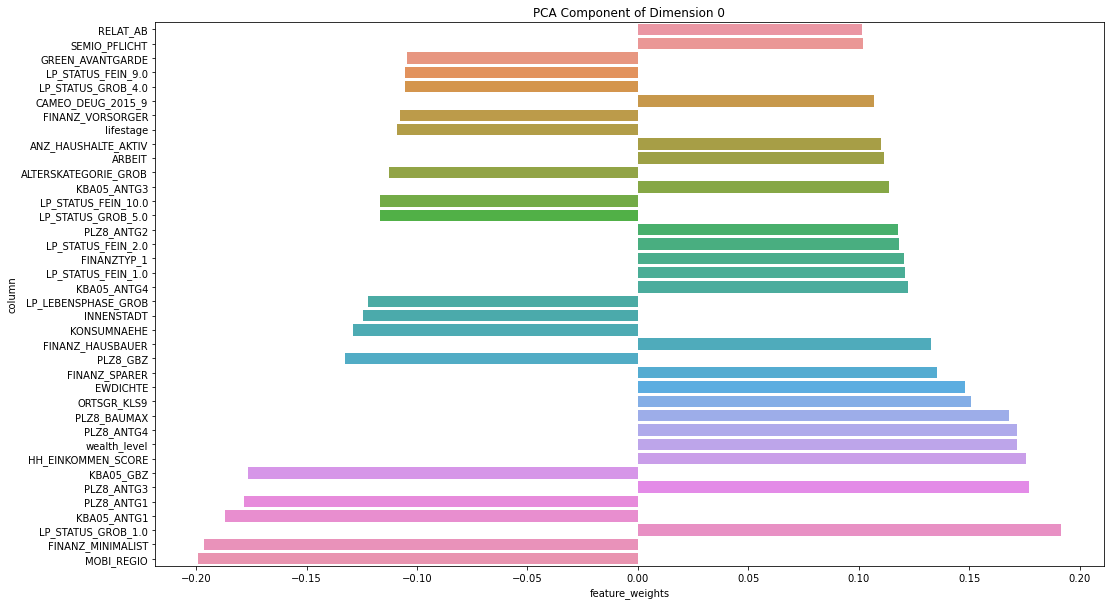

In [387]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

map_weights(df_cleaned, pca, 0, 0.1)

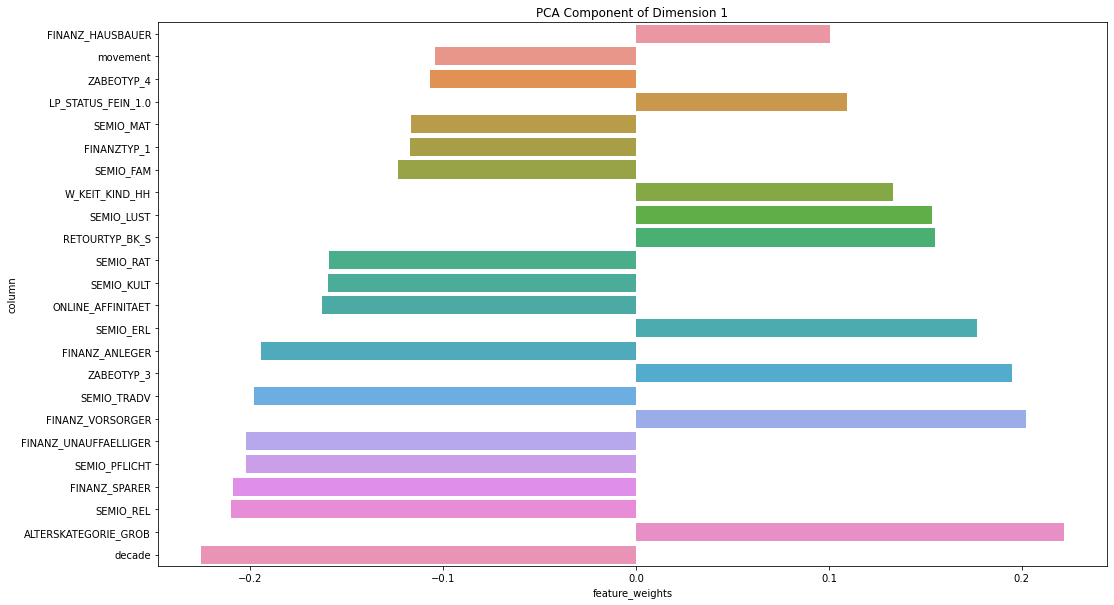

In [388]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights(df_cleaned, pca, 1, 0.1)

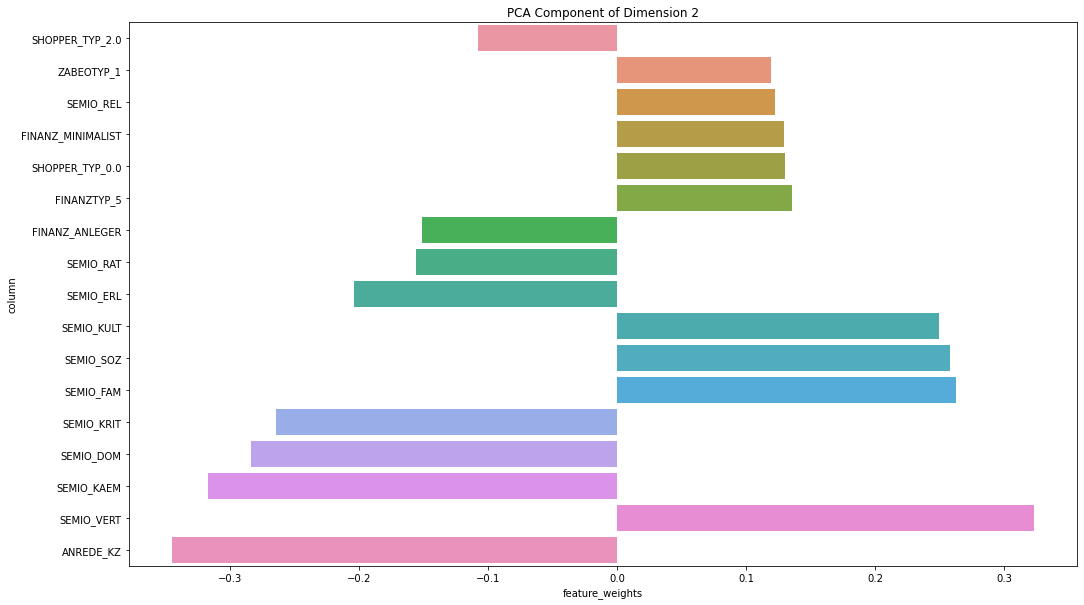

In [389]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights(df_cleaned, pca, 2, 0.1)

### Discussion 2.3: Interpret Principal Components
Summary of the top 6 most affected features by each principal component:

P - Positive
N - Negative

- 1st Component: 
    1. MOBI_REGIO => Mobility (N-Low movement)
    2. FINANZ_MINIMALIST => Finantial - minimalism affinity (N-Not minimalist)
    3. LP_STATUS_GROB_1.0 => Low Social status (P-Earns less)
    4. KBA05_ANTG1 => Number of 1-2 family houses in the microcell (N-Not many families)
    5. PLZ8_ANTG1 => Number of 1-2 family houses in the PLZ8 region (N-Not many families)
    6. PLZ8_ANTG3 => Number of 6-10 family houses in the PLZ8 region (P-Lots of families)
- 2nd Component: 
    1. decade => Youth decade (N-Old)
    2. ALTERSKATEGORIE_GROB => Estimated age (P-Old)
    3. FINANZ_SPARER => Finantial - money-saver affinity (N)
    4. SEMIO_REL => Personality - religious affinity (N)
    5. SEMIO_PFLICHT => Personality - dutiful affinity (N)
    6. FINANZ_VORSORGER => Finantial - be prepared affinity (P)
- 3rd Component: 
    1. ANREDE_KZ => Gender (N-Male)
    2. SEMIO_VERT => Personality - dreamful affinity (P)
    3. SEMIO_KAEM => Personality - combative attitude affinity (N)
    4. SEMIO_DOM => Personality - dominant-minded affinity (N)
    5. SEMIO_KRIT => Personality - critical-minded affinity (N)
    6. SEMIO_FAM => Personality - family-minded affinity (P)

The first component captures caracteristics portaining to a social and financial status. It positively describes traits associated with less wealth, such as densely packed family houses, low social status and low movement, while negatively describing traits associated with more wealth.

The second component positively describes attributes that generally lean towards older age (with a few exceptions), such as little money saving, financial preparedness and less dutifulness.

The third component, however, strongly captures Personality traits, with negative values for disruptive personality traits and positive values for more complacent, social and family-minded traits.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [206]:
df_scores = pd.DataFrame(columns = ['n_clusters', 'score'])

# PLEASE READ : This cell takes a long time to run and is not necessary for following steps, so consider this before running

# Code for a progress bar
toolbar_width = azdias.shape[1]
sys.stdout.write("KMeans testing progress: ")
sys.stdout.write("[%s]" % (" "))
sys.stdout.flush()
sys.stdout.write("\b" * (toolbar_width+1))

# Over a number of different cluster counts...
for k in range(2, 30):
    # progress bar
    sys.stdout.write("-")
    sys.stdout.flush()

    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k)
    model = kmeans.fit(X_pca)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(X_pca))
    
    df_score = pd.DataFrame([[k, score]], columns = ['n_clusters', 'score'])
    df_scores = df_scores.append(df_score)
    
sys.stdout.write(" ]\n")

KMeans testing progress: [---------------------------- ]


In [207]:
df_scores.head()

,n_clusters,score
0,2,6.770072e+07
0,3,6.393027e+07
0,4,6.166812e+07
0,5,5.996237e+07
0,6,5.868160e+07


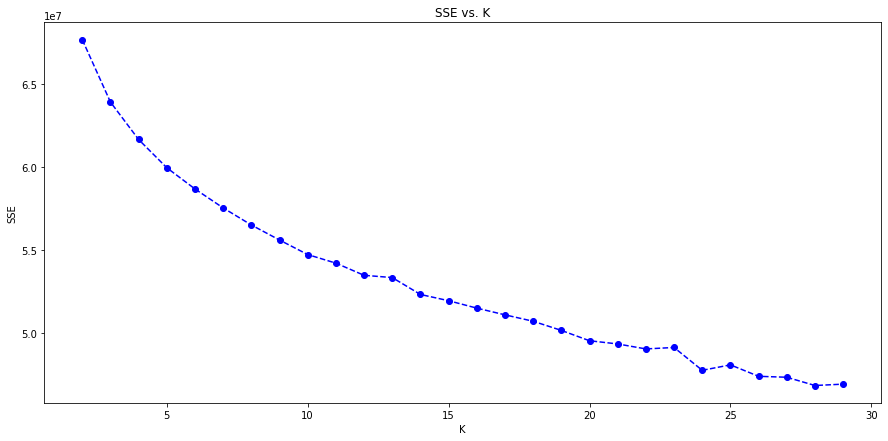

In [208]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize = [15, 7])
plt.title('SSE vs. K')

x = df_scores['n_clusters']
y = df_scores['score']
plt.xlabel('K');
plt.ylabel('SSE');

plt.plot(x, y, linestyle='--', marker='o', color='b');

In [209]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

k = 10

kmeans = KMeans(n_clusters=k)
model = kmeans.fit(X_pca)

### Discussion 3.1: Apply Clustering to General Population

After testing values from 2 to 29 clusters, I plotted a graph to show the decreasing distance of points per new cluster added. Then, I used the elbow method to decide upon a number of 10 clusters, because after this point the error starts to go down much slower. So for the final clustering model I divided the population into 10 different clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [390]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [391]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

df_customers, df_customers_N = clean_data(customers)

In [436]:
print(df_customers.shape)
print(df_customers_N.shape)

(115643, 144)
(50062, 144)


In [392]:
show_df_info(df_customers)

                                      column  nan_percentage     type
ALTERSKATEGORIE_GROB    ALTERSKATEGORIE_GROB             0.0  float64
ANREDE_KZ                          ANREDE_KZ             0.0    int64
FINANZ_MINIMALIST          FINANZ_MINIMALIST             0.0    int64
FINANZ_SPARER                  FINANZ_SPARER             0.0    int64
FINANZ_VORSORGER            FINANZ_VORSORGER             0.0    int64
FINANZ_ANLEGER                FINANZ_ANLEGER             0.0    int64
FINANZ_UNAUFFAELLIGER  FINANZ_UNAUFFAELLIGER             0.0    int64
FINANZ_HAUSBAUER            FINANZ_HAUSBAUER             0.0    int64
GREEN_AVANTGARDE            GREEN_AVANTGARDE             0.0    int64
HEALTH_TYP                        HEALTH_TYP             0.0  float64
LP_LEBENSPHASE_GROB      LP_LEBENSPHASE_GROB             0.0  float64
RETOURTYP_BK_S                RETOURTYP_BK_S             0.0  float64
SEMIO_SOZ                          SEMIO_SOZ             0.0    int64
SEMIO_FAM           

In [393]:
# Just for clarity's sake, I will be refitting the original general population dataset, so that these cells can be run instead
# of all the cells above

df_generalpop = df_cleaned;

In [394]:
# Fitting scaler to general population

scaler = StandardScaler()
generalpop_scaled = scaler.fit_transform(df_generalpop)

In [395]:
# Fitting pca to general population

pca = PCA(n_components=60)
generalpop_pca = pca.fit_transform(generalpop_scaled)

In [396]:
# Fitting kmeans to general population

kmeans = KMeans(n_clusters=10)
model = kmeans.fit(generalpop_pca)

In [454]:
clustered_generalpop = model.predict(generalpop_pca)
clustered_generalpop

array([4, 3, 1, ..., 4, 5, 1])

In [439]:
# Customers

customers_scaled = scaler.transform(df_customers)

In [440]:
customers_pca = pca.transform(customers_scaled)

In [456]:
clustered_customers = model.predict(customers_pca)

In [457]:
clustered_customers

array([2, 9, 1, ..., 2, 3, 6])

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [465]:
# Now to add the datapoints for the NaN generalpop rows
clustered_generalpop_with_nancluster = clustered_generalpop

for i in range(0, df_cleaned_N.shape[0]):
    clustered_generalpop_with_nancluster = np.append(clustered_generalpop_with_nancluster, 10)

In [463]:
# Now to add the datapoints for the NaN customer rows
clustered_customers_with_nancluster = clustered_customers

for i in range(0, df_customers_N.shape[0]):
    clustered_customers_with_nancluster = np.append(clustered_customers_with_nancluster, 10)

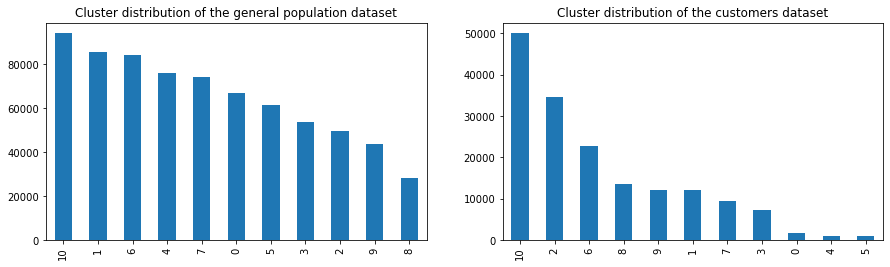

In [466]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

plt.figure(figsize = [15, 4]) 
    
plt.subplot(1, 2, 1);
plt.title('Cluster distribution of the general population dataset');
s = pd.Series(clustered_generalpop_with_nancluster)
s.value_counts().plot(kind="bar");

plt.subplot(1, 2, 2);
plt.title('Cluster distribution of the customers dataset');
s = pd.Series(clustered_customers_with_nancluster)
s.value_counts().plot(kind="bar");

In [467]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

df = df_cleaned

df["cluster"] = clustered_generalpop

In [468]:
df_2 = df.loc[df['cluster'] == 2]
df_2 = df_2.drop(columns=['cluster']);

df_scaled_2 = scaler.transform(df_2)
df_pca_2 = pca.transform(df_scaled_2)

df_2.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,decade,movement,wealth_level,lifestage
7,1.0,1,3,3,4,1,3,2,0,1.0,...,0,0,0,0,0,0,70,1,1,4
8,3.0,1,4,4,2,4,2,2,1,3.0,...,0,0,0,0,0,0,80,0,1,3
19,3.0,1,5,2,3,1,3,1,1,3.0,...,0,1,0,0,0,0,70,0,3,4
32,1.0,1,5,4,2,3,4,1,1,1.0,...,0,0,0,0,0,0,90,0,1,4
56,2.0,1,4,3,1,3,4,1,1,3.0,...,1,0,0,0,0,0,80,0,2,2


In [471]:
def plot_columns(df, columns):
    for i in range(0, len(attributes)):
        if((i%4)+1 == 1):
            fig = plt.figure(figsize=(15,8))
            fig.subplots_adjust(hspace=0.4, wspace=0.4)

        column = attributes[i]

        ax = fig.add_subplot(2, 2, (i%4)+1)
        g = sns.countplot(data=df, x=column);

    plt.show()

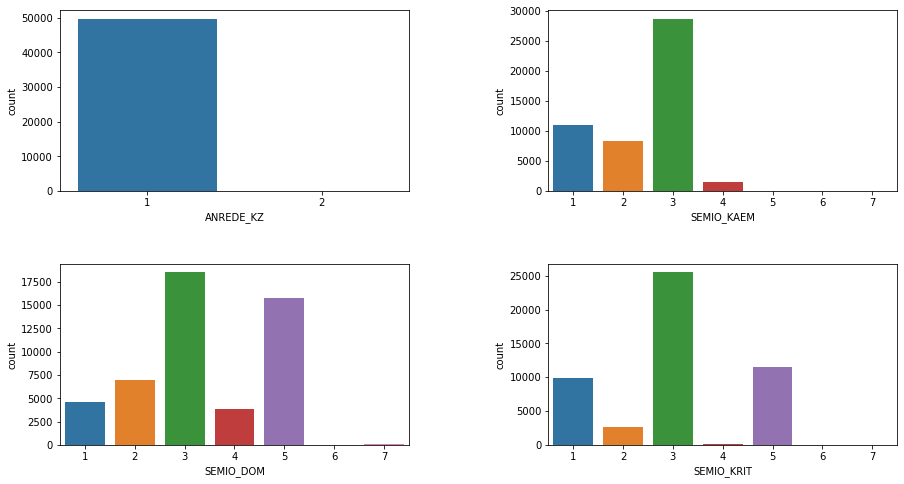

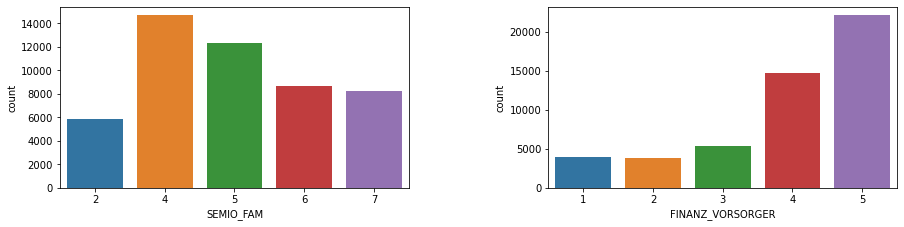

In [472]:
attributes = ['ANREDE_KZ', 'SEMIO_KAEM', 'SEMIO_DOM', 'SEMIO_KRIT', 'SEMIO_FAM', 'FINANZ_VORSORGER']

plot_columns(df_2, attributes)

In [473]:
def plot_pca_hist(data, dimension):
    arr = data[dimension]
    
    fig, ax = plt.subplots(figsize=[10,5])

    ax.set_title("Weight Frequency of PCA dimension  -  Mean " + "{:.3f}".format(arr.mean()))
    
    ax.set_xlabel("Weight")
    ax.set_ylabel("Frequency")

    N, bins, patches = ax.hist(arr, bins=50, color="#777777")

    for bin_size, bin, patch in zip(N, bins, patches):
        if bin_size == 50:
            patch.set_facecolor("b")
            patch.set_label("something")
    plt.show()

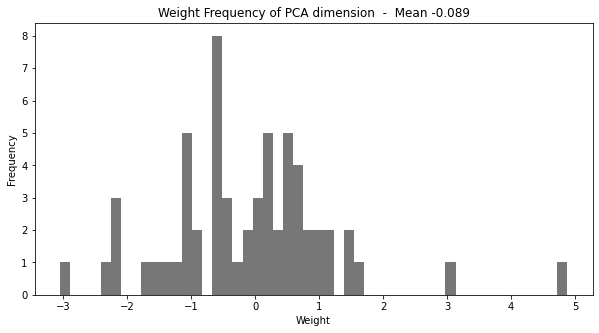

In [474]:
plot_pca_hist(df_pca_2, 0)

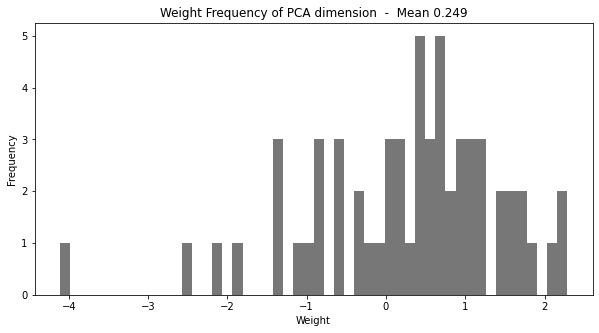

In [475]:
plot_pca_hist(df_pca_2, 1)

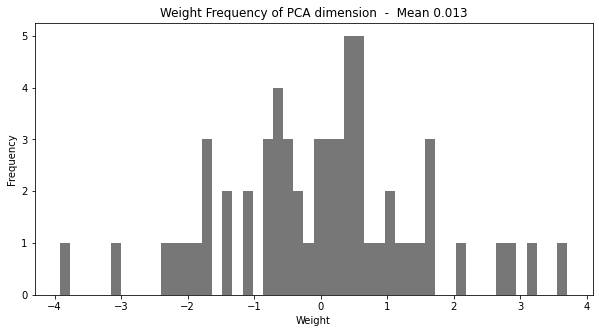

In [476]:
plot_pca_hist(df_pca_2, 2)

In [479]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

df_4 = df.loc[df['cluster'] == 4]

df_4 = df_4.drop(columns=['cluster']);

df_scaled_4 = scaler.transform(df_4)
df_pca_4 = pca.transform(df_scaled_4)

df_4.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,decade,movement,wealth_level,lifestage
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,0,90,1,5,1
31,2.0,2,1,5,2,3,5,4,0,1.0,...,0,0,0,0,0,1,80,1,5,1
43,1.0,2,1,5,3,5,5,5,0,3.0,...,1,0,0,0,0,0,90,1,2,5
52,1.0,2,1,4,2,2,4,3,0,3.0,...,0,0,0,0,1,0,90,1,4,1
57,1.0,2,1,5,3,5,3,5,0,3.0,...,0,0,0,1,0,0,90,1,4,1


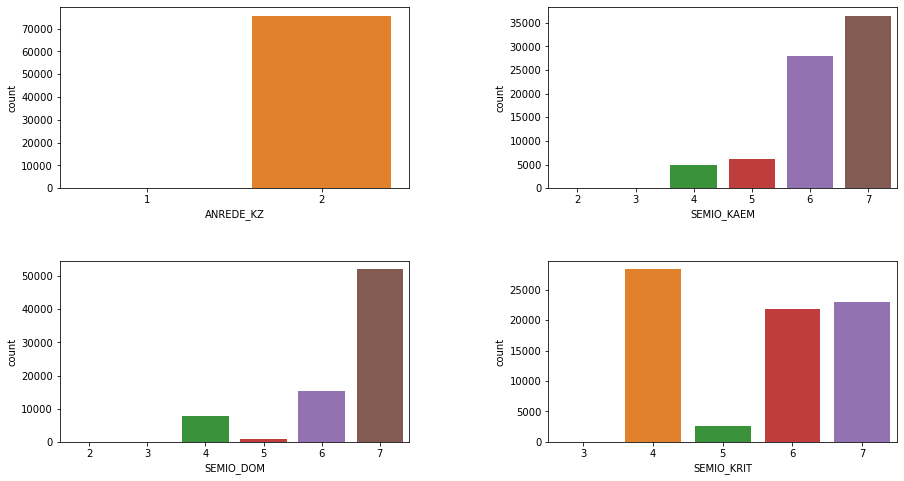

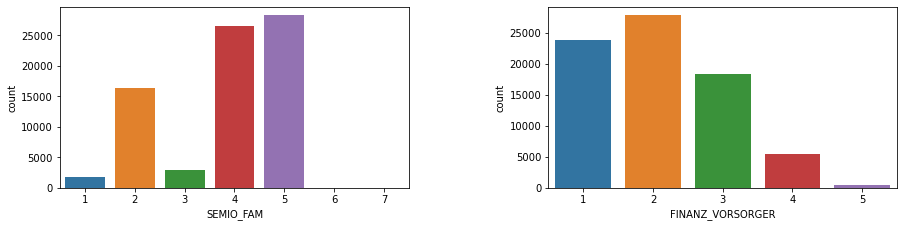

In [480]:
attributes = ['ANREDE_KZ', 'SEMIO_KAEM', 'SEMIO_DOM', 'SEMIO_KRIT', 'SEMIO_FAM', 'FINANZ_VORSORGER']

plot_columns(df_4, attributes)

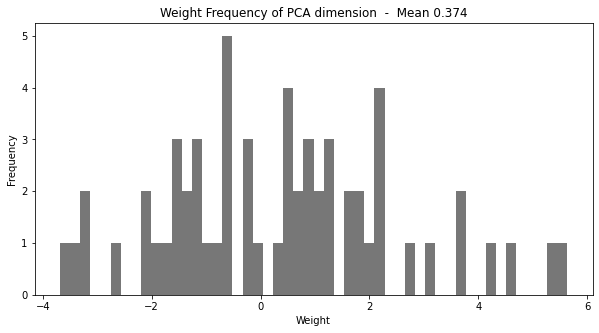

In [481]:
plot_pca_hist(df_pca_4, 0)

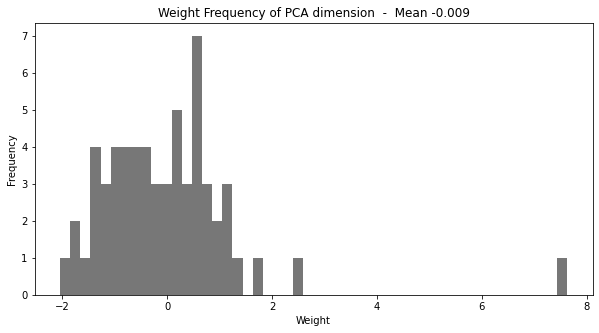

In [482]:
plot_pca_hist(df_pca_4, 1)

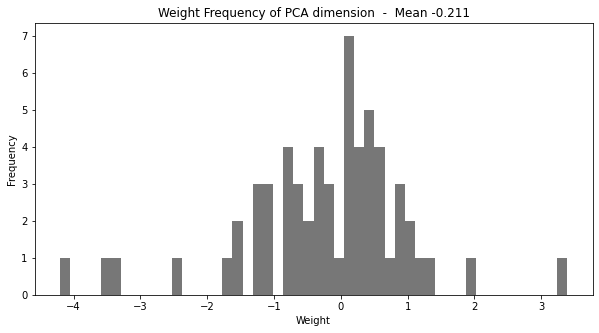

In [483]:
plot_pca_hist(df_pca_4, 2)

### Discussion 3.3: Compare Customer Data to Demographics Data

According to the comparisons between the customer and general population clusterings, the is a very prominent cluster of customers that is underrepresented in the general population, cluster number 2. Upon deeper analysis of this cluster, I could determine the following in regards to the 3 main principal components:

- 1st component (Low status and poorer high density families): The mean on this component is negative, but very close to 0, so one could say that this component doesn't tell us very much.

- 2nd component (Older population): On this component the mean is positive, and relatively far away from 0, so it tells us that our target demographic may be closer to an older age.

- 3rd component (Complacent and family minded): This component is positive, but again very close to 0, so it does not tell us much.


In regards to the less customer dense clusters, I found that cluster 4 represents a big chunk of the general population, whilst only representing a tiny part of the customer database, which means that it can tell us a lot about the people that aren't likely to become customers. So to analyze again with the 3 main principal components:

- 1st component (Low status and poorer high density families): Since the mean of the weights is noticeably positive here, it would be safe to assume that the target audience is more on the wealthy spectrum. This is because we are analysing the cluster which is likely not to represent customers, and it represents a positive value for the component that denotes poverty.

- 2nd component (Older population): This mean is negative, but very close to 0, so it doesn't tell us very much.

- 3rd component (Complacent and family minded): This mean is noticeably negative, so it can tell us about somethings about the personalities of unlikely customers. Since it is negative, this component tells us that more disruptive, less complacent and less family minded individuals are not likely to be customers. So customers are probably more complacent and family-minded.

In summary, here a few of the things one could say about our target demographic:

- It probably is in the more wealthy spectrum.
- It represents older people.
- It is more family oriented and complacent.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.